In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
words = open('names.txt', 'r').read().splitlines()

In [33]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [34]:
block_size = 3
X, Y = [], []
for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [35]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [61]:
block_size = 3 

def build_dataset(words):
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [37]:
C = torch.randn((27,2))

In [38]:
emb = C[X]

In [39]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [40]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [41]:
h.shape

torch.Size([228146, 100])

In [42]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [43]:
logits = h @ W2 + b2

In [44]:
logits.shape

torch.Size([228146, 27])

In [45]:
counts = logits.exp()

In [46]:
prob = counts / counts.sum(1, keepdims=True)

In [47]:
prob[0].sum()

tensor(1.)

In [48]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [49]:
sum(p.nelement() for p in parameters) #number of parameters

11897

In [50]:
for p in parameters:
    p.requires_grad=True

In [51]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [52]:
lri = []
lossi = []
stepi = []

In [53]:
for i in range(200000):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())

In [62]:
print(loss.item())    

2.160982370376587


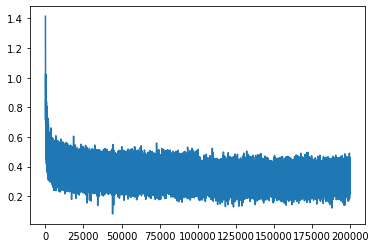

In [63]:
plt.plot(stepi, lossi)

In [64]:
# plt.plot(lri, lossi) #determing the proper learning rate

In [65]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1258, grad_fn=<NllLossBackward0>)

In [66]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1288, grad_fn=<NllLossBackward0>)

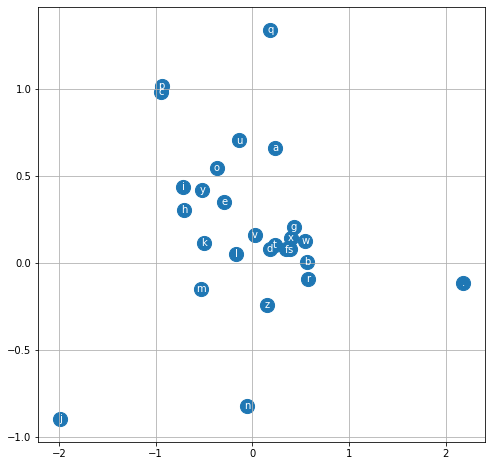

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [68]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

carmah.
quillivi.
kimri.
jehty.
ska.
sakona.
hube.
deliah.
jarqui.
nermara.
chaiir.
kaleigh.
ham.
jorn.
quinn.
shor.
marian.
quinathon.
jaryni.
jace.
